<a href="https://colab.research.google.com/github/dlevonian/california_renewables/blob/master/caiso_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAISO SOLAR

Solar generation is the centerpiece of California’s bold clean energy policies. However, the unpredictable nature of solar is one of the greatest challenges facing California’s grid operator CAISO today. 

The goal of this project is to identify the best method of predicting the solar generation for the purely autoregressive model in the absence of any external inputs. All forecasts below are built for 1-hour ahead horizon.

    
- [Shiny App](https://levonian.shinyapps.io/california_renewables/)
- [blog](https://nycdatascience.com/blog/student-works/california-renewables-predicting-solar-generation/)
- [github](https://github.com/dlevonian/california_renewables) 

In [0]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

import time
from datetime import datetime


In [0]:
!pip install git+https://github.com/statsmodels/statsmodels

In [3]:
import statsmodels.api as sm
import statsmodels.tsa.statespace.sarimax as S

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sm.__version__

'0.12.0.dev0+313.g0551e89f7'

In [4]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.2.0'

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# helper plot function
def plot_series(view, t, series_dict):
    """Args: 
         view, tuple or list of (t_start, t_end)
         t, array-like of timesteps (x axis)
         series_dist, dict of {'series_name': series}
    """
    view=slice(view[0], view[1])
    plt.figure(figsize=(10,4))
    for label, series in series_dict.items():
        plt.plot(t[view], series[view], label=label)
    plt.grid()
    plt.legend()
    plt.show()

In [0]:
path = '/content/drive/My Drive/NYCDSA/california_renewables/'  # Google Drive path

In [0]:
df = pd.read_csv(path+'caiso_final.csv')

In [11]:
df.head(5)

,DATE,HOUR,GEOTHERMAL,BIOMASS,BIOGAS,SMALL_HYDRO,WIND,SOLAR_PV,SOLAR_THERMAL,RENEWABLES,NUCLEAR,THERMAL,IMPORTS,HYDRO,TOTAL
0,20100420,1,1056,323,170,250,632,0,0,2431,3854,7707,4964,2514,21470
1,20100420,2,1055,318,169,245,632,0,0,2419,3859,7357,4651,2012,20298
2,20100420,3,1058,316,168,240,677,0,0,2460,3870,6765,4667,1914,19676
3,20100420,4,1063,318,168,238,923,0,0,2710,3887,6544,4823,1902,19866
4,20100420,5,1066,318,168,247,875,0,0,2674,3894,6623,4835,2213,20239


In [0]:
def datetime_from_integers(date_int, hour_int):
    date_str = str(date_int)
    hour_str = str(hour_int-1) 
    if len(hour_str)==1: hour_str='0'+hour_str
    return datetime.strptime(date_str+hour_str, '%Y%m%d%H')
dt = list(map(datetime_from_integers, df.DATE.values, df.HOUR.values))

In [13]:
df.dtypes

DATE             int64
HOUR             int64
GEOTHERMAL       int64
BIOMASS          int64
BIOGAS           int64
SMALL_HYDRO      int64
WIND             int64
SOLAR_PV         int64
SOLAR_THERMAL    int64
RENEWABLES       int64
NUCLEAR          int64
THERMAL          int64
IMPORTS          int64
HYDRO            int64
TOTAL            int64
dtype: object

In [14]:
df.shape

(87936, 15)

In [0]:
# COMBINE SOLAR PV AND THERMAL
series = df['SOLAR_PV'].values + df['SOLAR_THERMAL'].values

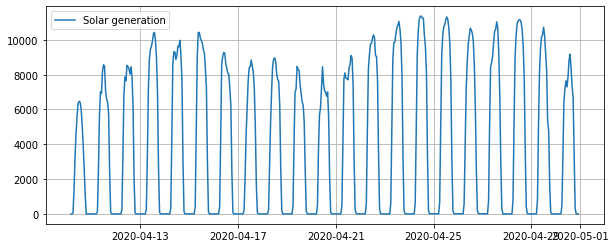

In [16]:
plot_series((-500,-1), dt, {'Solar generation': series})

In [0]:
split_time = 76_272    # January 1, 2019, 00:00

time_train = dt[:split_time]
x_train = series[:split_time]

time_test = dt[split_time:]
x_test = series[split_time:]


## Naive Forecast

The naive prediction of F(t+1)=F(t) often serves as a basic benchmark.

In [0]:
# A simple 1-hour ahead persistence forecast
naive_forecast = series[split_time-1:-1]

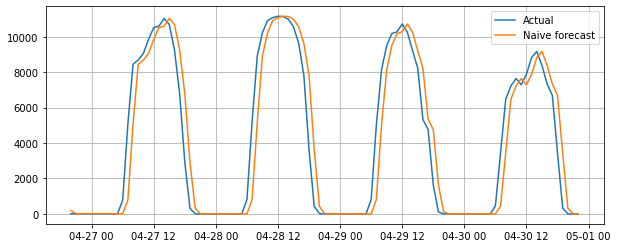

In [19]:
plot_series((-100,-1), time_test, {'Actual': x_test, 'Naive forecast': naive_forecast})

In [20]:
print(keras.metrics.mean_squared_error(x_test, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy())

1930753
738


## MA+Differencing

A slightly less naïve approach, applicable only for periodic series, relies on smoothing the signal as compared to previous periods.  This forecast does not learn any patterns directly from the data. 

We assume essentially an MA(1) process for the once-differenced I(1) series with fixed coefficients. A grid search of relevant parameters produced the optimal configuration, which turned out to be very simple: forecasting the next hour as the current generation (the pure naïve), adjusted for the difference in generation between the same adjacent timesteps 24 hours ago:

 S(t+1) = MA[S(t)-S(t-period)] + S(t+1-period)

In [0]:
def ma_forecast(series, window_size):
    """ NB: this moving average does NOT include the last observation
    and therefore is protected from data leakage at the basic level
    E.g. for the last times step, it produces a moving average
    MA = series[-1-window:-1].mean()
    """
    window_size = int(window_size)
    forecast = []
    for time in range(window_size, len(series)):
        forecast.append(series[time-window_size:time].mean())
    return np.array(forecast)


In [0]:
window_size=24
moving_avg = ma_forecast(series, window_size)

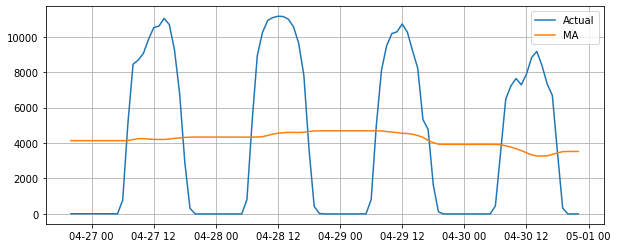

In [23]:
plot_series((-100,-1), time_test, {'Actual': x_test, 'MA': moving_avg})

In [0]:
def diff_forecast(series, split_time, period, ma_window):
    """ Implements period-based  differcing 
    NB: works well only for strictly periodic series such as 24 hours or 365 days
    S(t+1) = MA[S(t)-S(t-period)] + S(t+1-period)
    """
    diff_series = (series[period:] - series[:-period])
    diff_ma = ma_forecast(diff_series, ma_window)
    diff_ma = diff_ma[split_time - period - ma_window:]  # to sync with the test set

    forecast = diff_ma + series[split_time - period:-period] # add back the past
    forecast = np.floor(np.maximum(0, forecast))  # make sure non-negative

    return forecast


In [25]:
# Grid search for optimal period multiple and MA window
for period in range(24,168+1, 24):    # try periods from 1 day to 1 week
    print(f'PERIOD {period}', 50*'-')
   
    for ma_window in range(1,5):
        forecast = diff_forecast(series, split_time, period, ma_window)
        MAE = keras.metrics.mean_absolute_error(x_test, forecast).numpy()
        print(f'{period}  {ma_window}     MAE={MAE:.2f}')


PERIOD 24 --------------------------------------------------
24  1     MAE=214.03
24  2     MAE=264.17
24  3     MAE=305.02
24  4     MAE=336.88
PERIOD 48 --------------------------------------------------
48  1     MAE=241.70
48  2     MAE=302.27
48  3     MAE=350.21
48  4     MAE=387.47
PERIOD 72 --------------------------------------------------
72  1     MAE=246.01
72  2     MAE=309.23
72  3     MAE=356.85
72  4     MAE=394.39
PERIOD 96 --------------------------------------------------
96  1     MAE=254.71
96  2     MAE=320.03
96  3     MAE=370.26
96  4     MAE=409.36
PERIOD 120 --------------------------------------------------
120  1     MAE=264.70
120  2     MAE=332.37
120  3     MAE=385.98
120  4     MAE=427.67
PERIOD 144 --------------------------------------------------
144  1     MAE=266.34
144  2     MAE=334.98
144  3     MAE=389.56
144  4     MAE=431.85
PERIOD 168 --------------------------------------------------
168  1     MAE=264.37
168  2     MAE=331.80
168  3     MAE

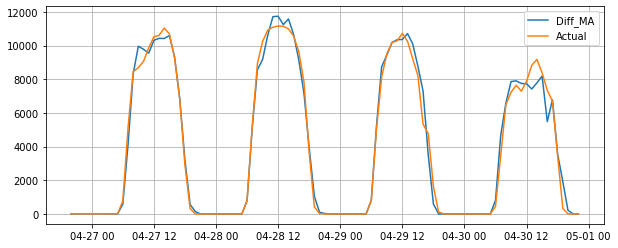

In [26]:
# Optimal MA_diff hyper-parameters: Period=24, ma_window=1
# which means S(t+1) = S(t) + [S(t+1-period) - S(t-period)]
diff_forecast = diff_forecast(series, split_time, 24, 1)

plot_series((-100,-1), time_test, {'Diff_MA': diff_forecast, 'Actual': x_test})

In [27]:
print(f'{keras.metrics.mean_squared_error(x_test, diff_forecast).numpy():.0f}')
print(f'{keras.metrics.mean_absolute_error(x_test, diff_forecast).numpy():.0f}')

181265
214


## SARIMA

Before we decide on which ML model to implement, we make a few observations about the solar generation:
- it is strictly periodic:
    - 24 hour period
    - weekly period from less solar being produced on the weekend when the energy demand is lower
    - annual period of daylight length and angle which affects photovolataic cell productivity
    


For SARIMA model, we will restric the train set to one year worth of data, specifically 2018. From a few empirical trials, this restriction does not affect the accuracy of predictions but greatly helps with statsmodels fit method's speed and memory. 

In [0]:
# 1 year (2018) of training data 
s_train = x_train[-8760:]

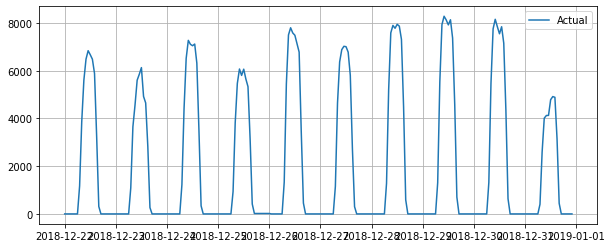

In [29]:
# The last 10 days of the traing set:
plot_series((-240,-1), time_train, {'Actual': s_train})

Let's see how the autocorrelation looks on the raw data before any differencing to get some intuition on 24-hour periods:

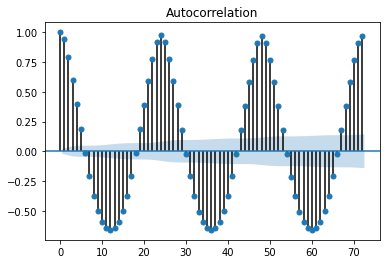

In [30]:
plot_acf(s_train, lags=72)
plt.show()

Seasonal ARIMA (SARIMA) is the appropriate method to account for seasonality (periodicity). The 24-hour differencing has to be the first step before we decide on AR(p) and MA(q) 


In [0]:
def differenced(series, period):
	diff = []
	for i in range(period, len(series)):
		diff.append(series[i]-series[i-period])
	return np.array(diff)

In [0]:
D_train = differenced(s_train, 24)

When we look closer at the 24-Differenced series, we see that it's still very far from a stationary process. NB the flat zero stretches are night data, but between the night stretches, the 24-Differenced series is clearly autocorrelated.

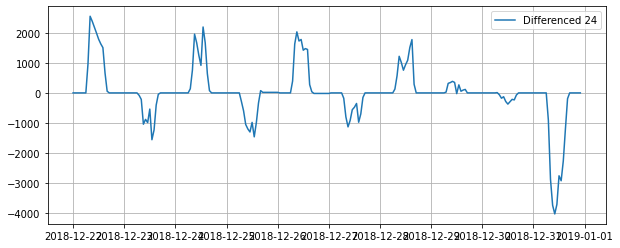

In [33]:
plot_series((-240,-1), time_train, {'Differenced 24': D_train})

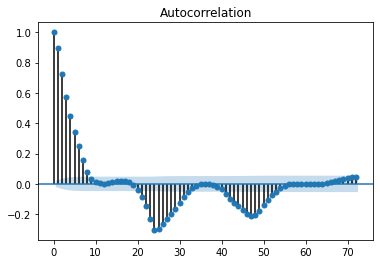

In [34]:
plot_acf(D_train, lags=72)
plt.show()

And therefore additional differencing is warranted, this time we subtract 1 period as is usually done in ARIMA

In [0]:
d_train = differenced(D_train, 1)

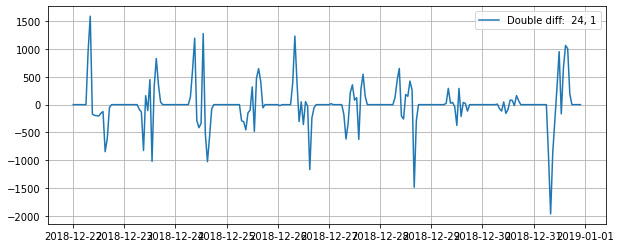

In [36]:
plot_series((-240,-1), time_train, {'Double diff:  24, 1': d_train})

This double-differenced data looks much closer to random stationary process, let's confirm this with the ACF/PACF plots

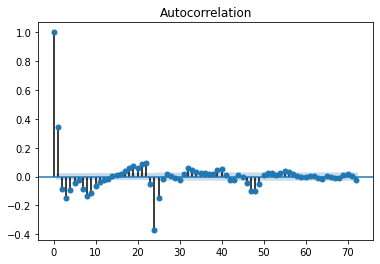

In [37]:
plot_acf(d_train, lags=72)
plt.show()

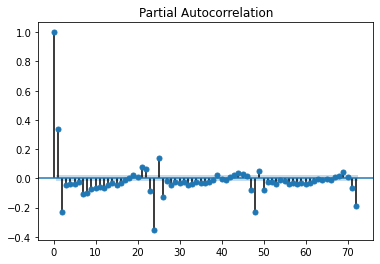

In [38]:
plot_pacf(d_train, lags=72)
plt.show()

The ACF plot tells us that the differenced series is  probably a MA(1) process. This means our model will adjust its predictions by some portion of the error it made in the previous timestep - which may have been caused by say extra cloud cover. When there is inertia in underlying DGP, MA(q) process is the appropriate choice, and there is clearly inertia in factors such as cloud cover, precipitation, and temperature. All of these factors tend to come in multi-hour stretches.

We also note the quite large autocorr. 24 hours ago, which is why we select the seasonal P also MA(1)

The PACF correlogram tells us that the AR order we should test is most probably is AR(2) and seasonal AR(2). We could have tested higher orders BUT there are two issues we need to keep in mind:
- compute time and memory, and 
- overfitting!

To summarize, we chose the following SARIMA model to fit:

SARIMA (p=2, d=1, q=1) (P=2, D=1, Q=1) period=24

In [39]:
tic = time.time()

s_model = sm.tsa.SARIMAX(s_train, order=(2,1,1), seasonal_order=(2,1,1,24))
res = s_model.fit(disp=True)

print(f'complete in  {time.time()-tic:.1f}')
print(res.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


complete in  248.4
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 8760
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 24)   Log Likelihood              -61743.042
Date:                            Fri, 22 May 2020   AIC                         123500.084
Time:                                    03:42:27   BIC                         123549.609
Sample:                                         0   HQIC                        123516.961
                                           - 8760                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2806      0.005    241.313      0.000       1.270       1.291
ar.L2         -0

In [0]:
extended_res = res.extend(endog=x_test)
sarima_forecast = extended_res.forecasts[0]

In [0]:
# make suure the forecasts are non-negative
sarima_forecast = np.floor(np.maximum(0, sarima_forecast))

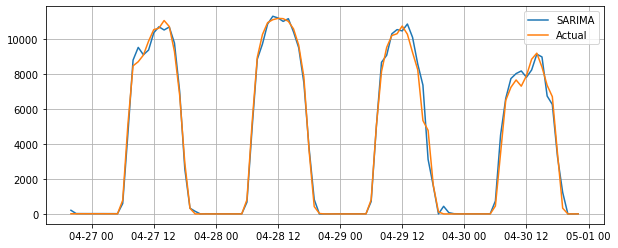

In [42]:
plot_series((-100,-1), time_test, {'SARIMA': sarima_forecast, 'Actual': x_test})

In [43]:
print(f'{keras.metrics.mean_squared_error(x_test, sarima_forecast).numpy():.5f}')
print(f'{keras.metrics.mean_absolute_error(x_test, sarima_forecast).numpy():.5f}')

111948.42533
175.54707


In [0]:
# free up memory
del s_model, res, extended_res

## LSTMs

RNN's performance is at about the same accruarce (or even slightly worse) as SARIMA's. Apparently, there is little non-linearity nor long-term dependencies which RNNs can pick up.
RNN seems to miss the peaks of the cycle more than SARIMA. If this bias proves to be systematic, it may be possible to compensate for. 


In [0]:
# reproducibility
tf.random.set_seed(2020)
np.random.seed(2020)


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = series[..., np.newaxis]
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [0]:
window_size =  48
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
x_train = x_train[-20_000:]

In [0]:
train_set = windowed_dataset(x_train, 
                             window_size=window_size, 
                             batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)

val_set = windowed_dataset(x_test, 
                             window_size=window_size, 
                             batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)


In [50]:
train_set.element_spec

(TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None))

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=[None, 1], return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
dense (Dense)                (None, None, 32)          2080      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='mae',   
              optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              metrics=['mae'])


In [0]:
def scheduler(epoch, lr):
    # keep the original lr for flat_period epochs, exponential decay since then subject to floor_lr
    flat_period, decay, floor_lr = (20, -0.025, 0.0001)
    if epoch<flat_period:   
        return lr
    else:  
        return max(lr*np.exp(decay), floor_lr)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [54]:
EPOCHS=100

tic = time.time()
history = model.fit(train_set, 
                    epochs=EPOCHS,  
                    validation_data=val_set,
                    callbacks=[lr_callback],
                    verbose=1)

toc = time.time()
print(f'complete {toc-tic:.2f}')


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/100
624/624 [==============================] - 7s 12ms/step - loss: 2779.4624 - mae: 2779.4614 - val_loss: 2831.7261 - val_mae: 2831.7253 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/100
624/624 [==============================] - 7s 11ms/step - loss: 2225.9673 - mae: 2225.9661 - val_loss: 2070.0488 - val_mae: 2070.0496 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/100
624/624 [==============================] - 7s 11ms/step - loss: 1339.4006 - mae: 1339.4011 - val_loss: 1112.4432 - val_mae: 1112.4436 - lr: 0.0010

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/100
624/624 [==============================] - 7s 11ms/step - loss: 576.7147 - mae: 576.7140 - val_loss: 526.9536 - val_mae: 526.9534 - lr: 0.0010

Epoch 00005: LearningRateSc

In [0]:
def model_forecast(model, series, window_size):
    series = series[..., np.newaxis]
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast


In [56]:
tic = time.time()
lstm_forecast = model_forecast(model, series, window_size)

toc = time.time()
print(f'complete {toc-tic:.2f}')

lstm_forecast.shape

complete 9.90


(87889, 48, 1)

In [0]:
lstm_forecast = np.squeeze(lstm_forecast[split_time - window_size:-1, -1, 0])
lstm_forecast = np.floor(np.maximum(0, lstm_forecast))

In [58]:
print(keras.metrics.mean_squared_error(x_test, lstm_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_test, lstm_forecast).numpy())

118770.06
180.60194


In [0]:
# 168 hours    kernel_size=8
# 115736.87
# 185.73268

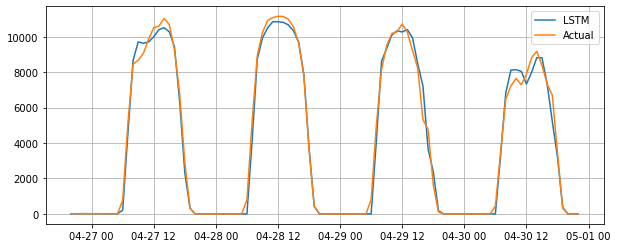

In [60]:
plot_series((-100,-1), time_test, {'LSTM': lstm_forecast, 'Actual': x_test})

Visualize Loss history and LR schedule

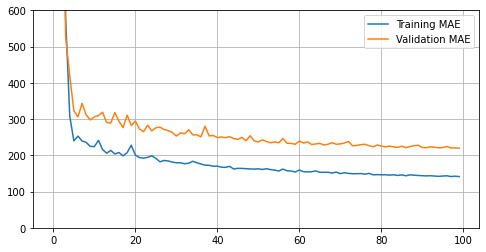

In [61]:
hdict = history.history

mx,val_mx,loss,val_loss = hdict['mae'],hdict['val_mae'],hdict['loss'],hdict['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 4))

plt.plot(epochs_range, mx, label='Training MAE')
plt.plot(epochs_range, val_mx, label='Validation MAE')

plt.ylim(0,600) 
plt.legend()
plt.grid()
plt.show()

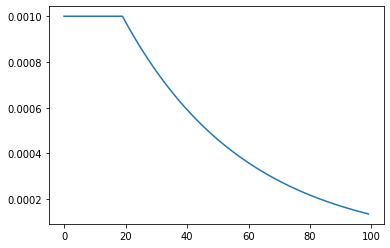

In [62]:
X=np.arange(EPOCHS)
Y=[]
lr=0.001
for x in X:
    lr = scheduler(x, lr)
    Y.append(lr)
plt.plot(X,Y)

## Ensemble

Ensemble is a simple average between SARIMA and LSTM.  Provides significant improivement compared to both models.

In [63]:
ensemble_forecast = 0.5*sarima_forecast + 0.5*lstm_forecast
print(keras.metrics.mean_absolute_error(x_test, ensemble_forecast).numpy())

161.76603223593963


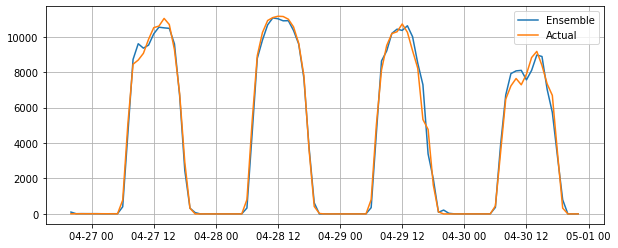

In [64]:
plot_series((-100,-1), time_test, {'Ensemble': ensemble_forecast, 'Actual': x_test})

In [65]:
print(naive_forecast.shape)
print(diff_forecast.shape)
print(sarima_forecast.shape)
print(lstm_forecast.shape)
print(ensemble_forecast.shape)

(11664,)
(11664,)
(11664,)
(11664,)
(11664,)


In [0]:
forecast_df = pd.DataFrame(data={'DATE':dt[split_time:],
                                 'SOLAR':series[split_time:],
                                 'F_NAIVE':naive_forecast,
                                 'F_DIFF':diff_forecast,
                                 'F_SARIMA': sarima_forecast,
                                 'F_LSTM':lstm_forecast,
                                 'F_ENSEMBLE':ensemble_forecast
})

In [0]:
forecast_df.to_csv(path+'caiso_forecasts.csv')